In [97]:
library(lme4)
library(lmerTest)
library(ggeffects)
library(ggplot2)
library(dplyr)
library(emmeans)
library(car)
library(ggrepel)
library(texreg)
library(MuMIn)

# Main study

## load novelty data


    0     1 
15261   771 


    0     1 
15292   740 

[1] 16031    14

[1] 0


    0     1 
15261   770 


human olmo1 olmo2 
 7657  4384  3990 

,batch,gen_passage_id,seed_passage_id,novel,meaningful,pragmatic,annotator_id,gen_source,ppl,WQRM_score,ai_likelihood,annotator,ppl_log_std,creative
,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>",<dbl>
1,1,16897_human,16897,0,1,1,9,human,4529.581,8.509995,0.000136031,9,0.195584,0
2,1,16897_human,16897,0,1,1,21,human,4529.581,8.509995,0.000136031,21,0.195584,0
3,1,16897_human,16897,0,1,1,20,human,4529.581,8.509995,0.000136031,20,0.195584,0


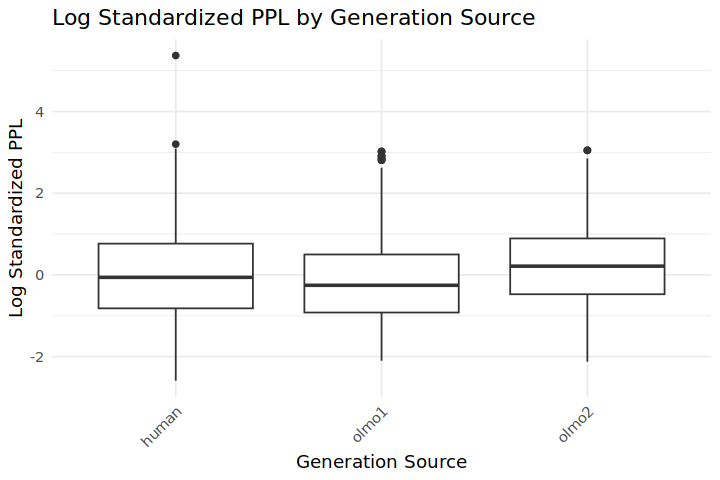

In [98]:
nov_data <- read.csv("../data/for_linear_models/prehlt_and_hlt.csv")
nov_data <- nov_data[nov_data$batch != 11, ]
nov_data$seed_passage_id <- as.factor(nov_data$seed_passage_id)
nov_data$annotator <- as.factor(nov_data$annotator_id)
nov_data$gen_source <- as.factor(nov_data$gen_source)
nov_data$gen_source <- relevel(nov_data$gen_source, ref = "human")
nov_data$ppl_log_std <- scale(log(nov_data$ppl))

table(nov_data$novel)
# if pragmatic or meaningful is not na and is 0, set novel to 0 (ignore NA)
nov_data$creative <- ifelse((!is.na(nov_data$pragmatic) & nov_data$pragmatic == 0) | 
                             (!is.na(nov_data$meaningful) & nov_data$meaningful == 0), 0, nov_data$novel)
table(nov_data$creative)

options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(nov_data, aes(x=gen_source, y=ppl_log_std)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Log Standardized PPL by Generation Source",
       x="Generation Source",
       y="Log Standardized PPL") +
  theme(axis.text.x = element_text(angle=45, hjust=1))

# remove the outlier expression
nov_data <- nov_data[nov_data$ppl_log_std < 4, ]
dim(nov_data)
# number of unique annotators
length(unique(nov_data$expression))
table(nov_data$novel)
table(nov_data$gen_source)
# first few rows
head(nov_data, n=3)

In [99]:
table(nov_data$novel, nov_data$pragmatic)
table(nov_data$novel, nov_data$meaningful)

table(nov_data$creative, nov_data$pragmatic)
table(nov_data$creative, nov_data$meaningful)

   
       0    1
  0  639 6358
  1   28  742

   
       0    1
  0  234 6763
  1   18  752

   
       0    1
  0  667 6361
  1    0  739

   
       0    1
  0  252 6776
  1    0  739

## novelty analysis

In [100]:
m_nov_ppl_g = glmer(creative ~ ppl_log_std 
                    + (1 | gen_source)
                    + (1 | annotator) 
                    + (1 | seed_passage_id), 
               data = nov_data, family = binomial(link = "logit"))
summary(m_nov_ppl_g)

# get odds ratio
exp(fixef(m_nov_ppl_g))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: creative ~ ppl_log_std + (1 | gen_source) + (1 | annotator) +  
    (1 | seed_passage_id)
   Data: nov_data

      AIC       BIC    logLik -2*log(L)  df.resid 
   5210.5    5248.9   -2600.2    5200.5     16026 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2968 -0.2239 -0.1508 -0.1044 17.7461 

Random effects:
 Groups          Name        Variance Std.Dev.
 seed_passage_id (Intercept) 0.37357  0.6112  
 annotator       (Intercept) 0.55453  0.7447  
 gen_source      (Intercept) 0.09295  0.3049  
Number of obs: 16031, groups:  
seed_passage_id, 50; annotator, 26; gen_source, 3

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.68004    0.25206  -14.60   <2e-16 ***
ppl_log_std  0.67536    0.04063   16.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effe

(Intercept) ppl_log_std 
 0.02522201  1.96473118

In [101]:
print(r.squaredGLMM(m_nov_ppl_g))

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                   R2m        R2c
theoretical 0.09552894 0.30975404
delta       0.01842459 0.05974202


In [102]:
formula_name <- "\\shortstack[l]{creative \\textasciitilde{} ppl\\_log\\_std + \\\\ 
(1 \\textbar{} gen\\_source) + (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"

texreg(m_nov_ppl_g,
       caption = "Mixed-effects logistic regression predicting creativity from standardized PPL",
       custom.model.names = formula_name,
       label = "tab:glmer_ppl",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/nov_ppl.tex")  # writes LaTeX table

The table was written to the file 'latex/nov_ppl.tex'.




Warning message in predict.merMod(m_nov_ppl_g, newdata, type = "link", re.form = NA, :
“se.fit computation uses an approximation to estimate the sampling distribution of the parameters”


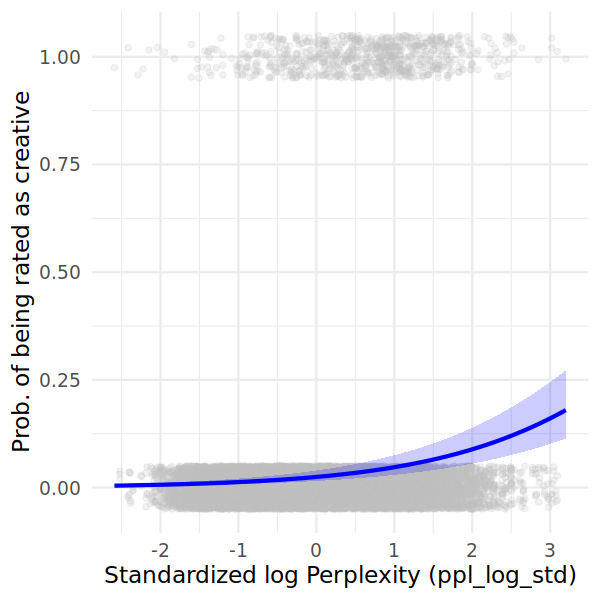

In [103]:
newdata <- data.frame(ppl_log_std = seq(
  min(nov_data$ppl_log_std),
  max(nov_data$ppl_log_std),
  length.out = 100
))

# Get predictions on the link (logit) scale with standard errors
pred_link <- predict(m_nov_ppl_g, newdata, type = "link", re.form = NA, se.fit = TRUE)

# Compute 95% confidence intervals on the probability scale
newdata$pred_prob <- plogis(pred_link$fit)
newdata$lower <- plogis(pred_link$fit - 1.96 * pred_link$se.fit)
newdata$upper <- plogis(pred_link$fit + 1.96 * pred_link$se.fit)

options(repr.plot.width = 5, repr.plot.height = 5)
ggplot() +
  # Observed points (jittered)
  geom_jitter(data = nov_data, aes(x = ppl_log_std, y = as.numeric(novel)), 
              height = 0.05, alpha = 0.2, color = "gray") +
  # Predicted probability curve
  geom_line(data = newdata, aes(x = ppl_log_std, y = pred_prob), 
            color = "blue", size = 1.2) +
  # Shaded 95% confidence interval
  geom_ribbon(data = newdata, aes(x = ppl_log_std, ymin = lower, ymax = upper), 
              fill = "blue", alpha = 0.2) +
  labs(
    x = "Standardized log Perplexity (ppl_log_std)",
    y = "Prob. of being rated as creative",
    # title = "Effect of ppl_log_std on Predicted Novelty with 95% CI"
  ) +
  theme_minimal(base_size = 14)
# save plot
ggsave("plots/novelty_vs_ppl_log_std.png", width = 5, height = 5, dpi = 300, bg = "white")

In [104]:
# show what % of novel expressions have low ppl
mean_ppl <- mean(nov_data$ppl_log_std)
low_ppl <- nov_data$ppl_log_std < mean_ppl

# Only consider novel texts
novel_texts <- nov_data$creative == 1

# Fraction of novel texts that have low perplexity
frac_novel_low <- mean(low_ppl[novel_texts])
frac_novel_low


q25 <- quantile(nov_data$ppl_log_std, 0.25)
bottom_quartile <- nov_data$ppl_log_std < q25
frac_novel_q25 <- mean(bottom_quartile[novel_texts] == 1)
frac_novel_q25

[1] 0.2395129

[1] 0.07171854

In [105]:
# show what % of high ppl expresssions are not novel
mean_ppl <- mean(nov_data$ppl_log_std)
high_ppl <- nov_data$ppl_log_std > mean_ppl

# Only consider high ppl texts
high_ppl_texts <- high_ppl == 1

# Fraction of high ppl texts that are not novel
frac_high_not_novel <- mean(nov_data$creative[high_ppl_texts] == 0)
frac_high_not_novel

# show what % of high ppl expresssions are not novel
q75 <- quantile(nov_data$ppl_log_std, 0.75)
top_quartile <- nov_data$ppl_log_std > q75
frac_novel_q75 <- mean(nov_data$novel[top_quartile] == 0)
frac_novel_q75

[1] 0.9285896

[1] 0.9051423

## load pragmatic data

[1] 7768   11

[1] 7516   13

[1] 0


   0    1 
 428 7088 


human olmo1 olmo2 
 3527  1871  2118 

,batch,gen_passage_id,seed_passage_id,novel,meaningful,pragmatic,annotator_id,gen_source,ppl,WQRM_score,ai_likelihood,annotator,ppl_log_std
,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>"
1,1,16897_human,16897,0,1,1,9,human,4529.581,8.509995,0.000136031,9,-0.2396703
2,1,16897_human,16897,0,1,1,21,human,4529.581,8.509995,0.000136031,21,-0.2396703
3,1,16897_human,16897,0,1,1,20,human,4529.581,8.509995,0.000136031,20,-0.2396703


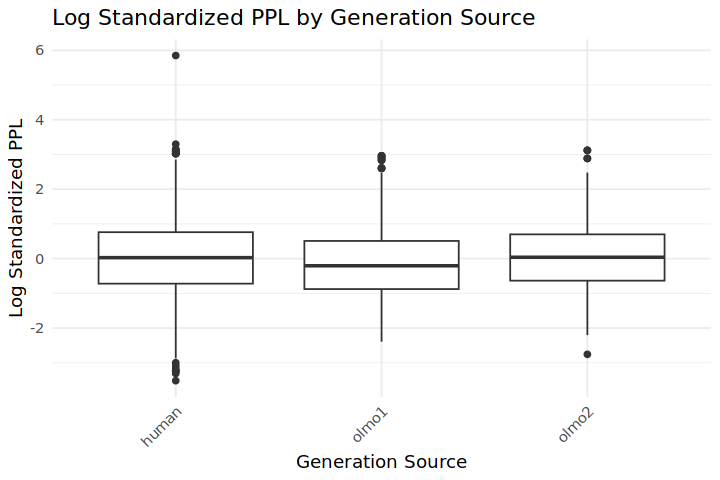

In [156]:
# Load the dataset
prag_data <- read.csv("../data/for_linear_models/prehlt_and_hlt.csv")
# to reproduce pre-hilight only results:
# prag_data <- read.csv("../data/for_linear_models/prehlt_only.csv")

prag_data <- prag_data[prag_data$batch != 11, ]
# # filter out rows where pragmatic is NA
prag_data <- prag_data[!is.na(prag_data$pragmatic), ]
dim(prag_data)

prag_data <- prag_data[prag_data$meaningful != 0, ]

prag_data$seed_passage_id <- as.factor(prag_data$seed_passage_id)
prag_data$annotator <- as.factor(prag_data$annotator)
prag_data$gen_source <- as.factor(prag_data$gen_source)
prag_data$gen_source <- relevel(prag_data$gen_source, ref = "human")
prag_data$ppl_log_std <- scale(log(prag_data$ppl))

options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(prag_data, aes(x=gen_source, y=ppl_log_std)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Log Standardized PPL by Generation Source",
       x="Generation Source",
       y="Log Standardized PPL") +
  theme(axis.text.x = element_text(angle=45, hjust=1))

dim(prag_data)
# number of unique annotators
length(unique(prag_data$expression))
table(prag_data$pragmatic)
table(prag_data$gen_source)
# first few rows
head(prag_data, n=3)

## pragmatic analysis

In [157]:
# how many are meaningful but not pragmatic?
table(prag_data$pragmatic)
table(prag_data$meaningful, prag_data$pragmatic)


   0    1 
 428 7088 

   
       0    1
  1  428 7088

In [158]:
m_prag_ppl = glmer(pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | seed_passage_id), 
               data = prag_data, family = binomial(link = "logit"))
print(r.squaredGLMM(m_prag_ppl))
summary(m_prag_ppl)
fixef(m_prag_ppl)["ppl_log_std"]
print(linearHypothesis(m_prag_ppl, "ppl_log_std = 0"))
fixef(m_prag_ppl)["ppl_log_std"] + fixef(m_prag_ppl)["ppl_log_std:gen_sourceolmo1"]
print(linearHypothesis(m_prag_ppl, c("ppl_log_std + ppl_log_std:gen_sourceolmo1 = 0")))
fixef(m_prag_ppl)["ppl_log_std"] + fixef(m_prag_ppl)["ppl_log_std:gen_sourceolmo2"]
print(linearHypothesis(m_prag_ppl, c("ppl_log_std + ppl_log_std:gen_sourceolmo2 = 0")))

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                   R2m       R2c
theoretical 0.09363842 0.4665354
delta       0.03173207 0.1580989


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 |  
    seed_passage_id)
   Data: prag_data

      AIC       BIC    logLik -2*log(L)  df.resid 
   2763.1    2818.5   -1373.5    2747.1      7508 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-15.0105   0.0832   0.1569   0.2482   1.4541 

Random effects:
 Groups          Name        Variance Std.Dev.
 seed_passage_id (Intercept) 0.3143   0.5606  
 annotator       (Intercept) 1.9853   1.4090  
Number of obs: 7516, groups:  seed_passage_id, 50; annotator, 26

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  3.91419    0.31404  12.464  < 2e-16 ***
ppl_log_std                  0.01930    0.08908   0.217  0.82852    
gen_sourceolmo1             -1.47533    0.15846  -9.310  < 2e-16 ***
gen_sourceolmo2              0.435

ppl_log_std 
 0.01929511

Linear hypothesis test

Hypothesis:
ppl_log_std = 0

Model 1: restricted model
Model 2: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | 
    seed_passage_id)

  Df  Chisq Pr(>Chisq)
1                     
2  1 0.0469     0.8285


ppl_log_std 
 -0.1746487

Linear hypothesis test

Hypothesis:
ppl_log_std  + ppl_log_std:gen_sourceolmo1 = 0

Model 1: restricted model
Model 2: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | 
    seed_passage_id)

  Df  Chisq Pr(>Chisq)  
1                       
2  1 4.8368    0.02786 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


ppl_log_std 
 -0.4839629

Linear hypothesis test

Hypothesis:
ppl_log_std  + ppl_log_std:gen_sourceolmo2 = 0

Model 1: restricted model
Model 2: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | 
    seed_passage_id)

  Df Chisq Pr(>Chisq)    
1                        
2  1 13.79  0.0002045 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [159]:
# get the fixed effect coefficient for ppl_log_std
fixef(m_prag_ppl)["ppl_log_std"]
fixef(m_prag_ppl)["ppl_log_std"] + fixef(m_prag_ppl)["ppl_log_std:gen_sourceolmo1"]
fixef(m_prag_ppl)["ppl_log_std"] + fixef(m_prag_ppl)["ppl_log_std:gen_sourceolmo2"]

ppl_log_std 
 0.01929511

ppl_log_std 
 -0.1746487

ppl_log_std 
 -0.4839629

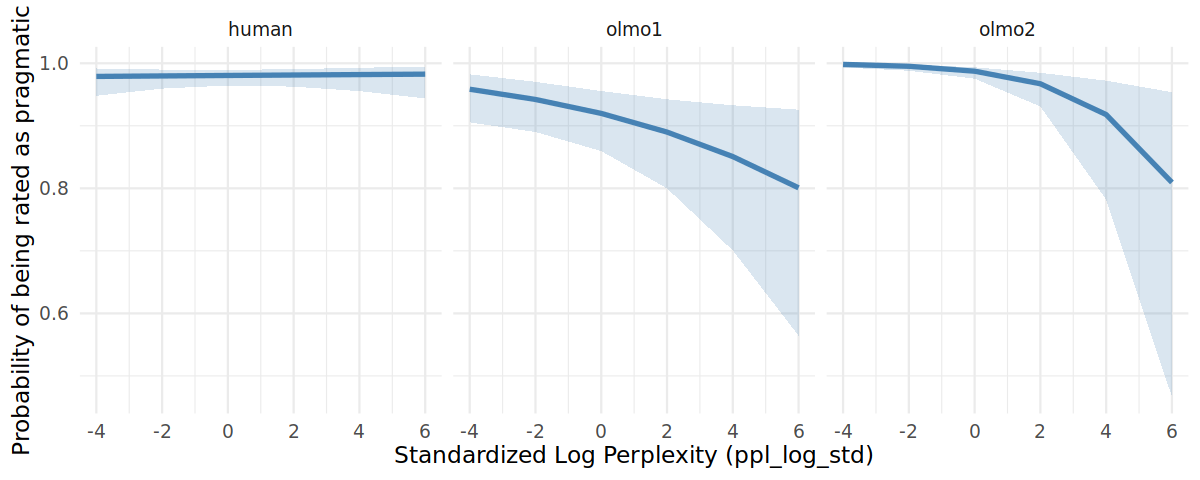

In [160]:
pragmatic_preds <- ggeffect(m_prag_ppl, terms = c("ppl_log_std", "gen_source"), bias_correction = TRUE)
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(pragmatic_preds, aes(x = x, y = predicted)) +
  geom_line(size = 1.5, color = "steelblue") +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.2, fill = "steelblue") +
  facet_wrap(~group) +
  labs(
    # title = "Predicted Pragmatism by Generation Source",
    x = "Standardized Log Perplexity (ppl_log_std)",
    y = "Probability of being rated as pragmatic"
  ) +
  theme_minimal(base_size = 14)

# save plot
ggsave("plots/pragmatism_vs_ppl_log_std_horiz.png", width = 10, height = 4, dpi = 300, bg = "white")

In [161]:
formula_name <- "\\shortstack[l]{pragmatic \\textasciitilde{} ppl\\_log\\_std * gen\\_source  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"
# pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | seed_passage_id)
texreg(m_prag_ppl,
       caption = "Mixed-effects logistic regression predicting creativity from standardized PPL",
       custom.model.names = formula_name,
       label = "tab:glmer_ppl_prag_src",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/prag_ppl.tex")  # writes LaTeX table

The table was written to the file 'latex/prag_ppl.tex'.




## ai likelihood analysis

In [162]:
h_prag_data = prag_data[prag_data$gen_source == "human", ]
h_prag_data$std_log_ai_likelihood = scale(log(h_prag_data$ai_likelihood))
h_prag_data$std_ai_likelihood = scale(h_prag_data$ai_likelihood)
h_prag_data$ppl_log_std <- scale(log(h_prag_data$ppl))
table(h_prag_data$pragmatic)

h_nov_data = nov_data[nov_data$gen_source == "human", ]
h_nov_data$std_log_ai_likelihood = scale(log(h_nov_data$ai_likelihood))
h_nov_data$std_ai_likelihood = scale(h_nov_data$ai_likelihood)
h_nov_data$ppl_log_std <- scale(log(h_nov_data$ppl))
table(h_nov_data$novel)
table(h_nov_data$creative)


   0    1 
 137 3390 


   0    1 
7187  470 


   0    1 
7203  454 

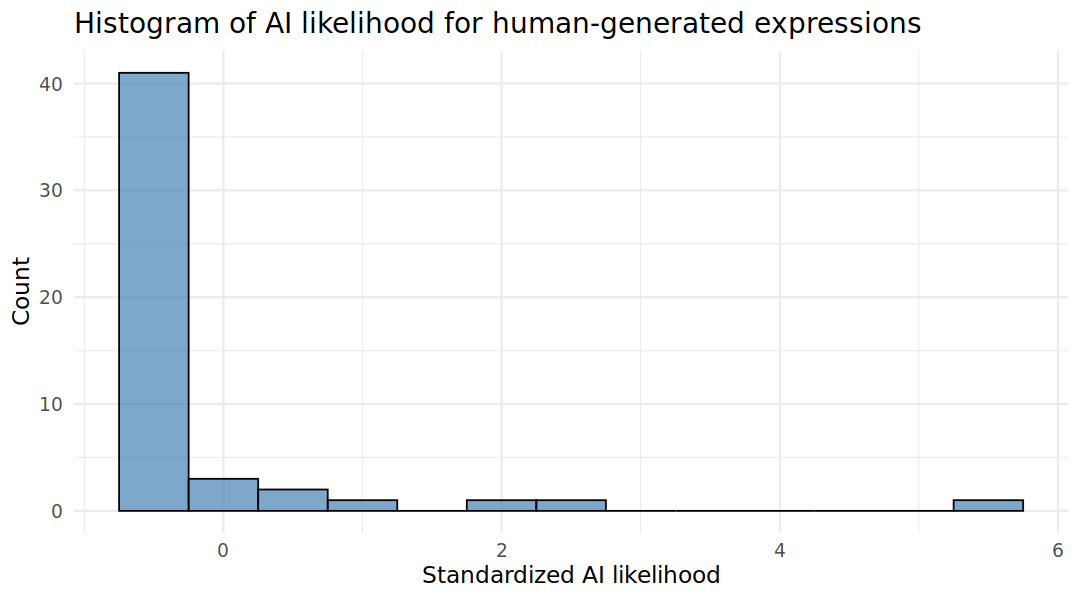

In [163]:
options(repr.plot.width = 9, repr.plot.height = 5)

# get unduplicated h_nov_data by gen_passage_id
undup_h_nov_data <- h_nov_data[!duplicated(h_nov_data$gen_passage_id), ]
ggplot(undup_h_nov_data, aes(x = std_ai_likelihood)) +
  geom_histogram(binwidth = 0.5, fill = "steelblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of AI likelihood for human-generated expressions",
      x = "Standardized AI likelihood",
       y = "Count") +
  theme_minimal(base_size = 14)

# save
# ggsave("plots/human_log_ai_likelihood_hist.png", width = 9, height = 5, dpi = 300, bg = "white")
# ggsave("plots/human_ai_likelihood_hist.png", width = 9, height = 5, dpi = 300, bg = "white")

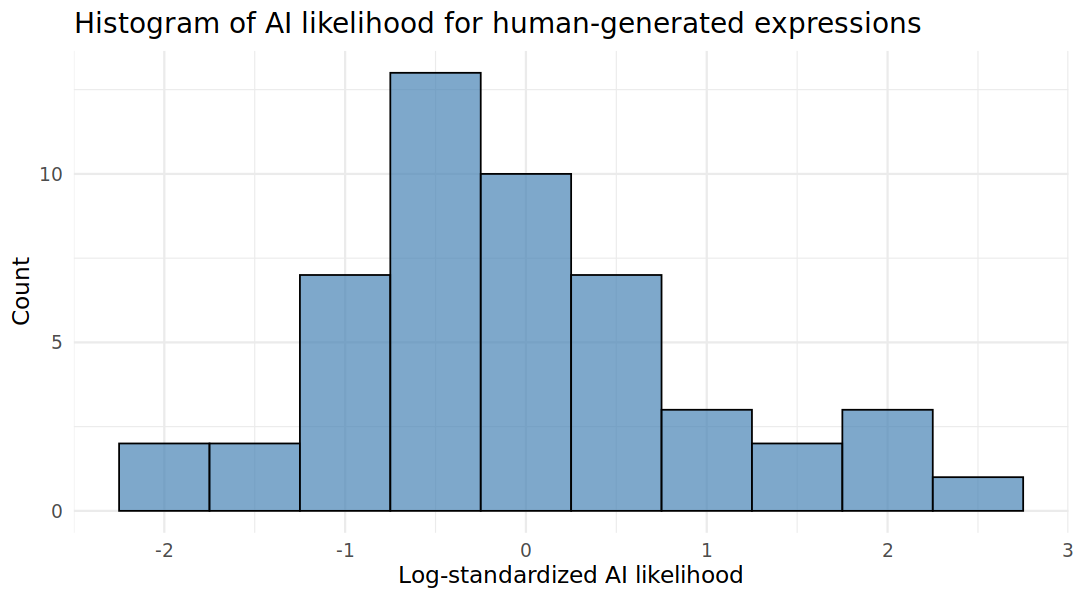

In [164]:
options(repr.plot.width = 9, repr.plot.height = 5)

# get unduplicated h_nov_data by gen_passage_id
undup_h_nov_data <- h_nov_data[!duplicated(h_nov_data$gen_passage_id), ]
ggplot(undup_h_nov_data, aes(x = std_log_ai_likelihood)) +
  geom_histogram(binwidth = 0.5, fill = "steelblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of AI likelihood for human-generated expressions",
       x = "Log-standardized AI likelihood",
       y = "Count") +
  theme_minimal(base_size = 14)

# save
ggsave("plots/human_log_ai_likelihood_hist.png", width = 9, height = 5, dpi = 300, bg = "white")

In [165]:
m_prag_ail = glmer(pragmatic ~ std_log_ai_likelihood 
                                + (1 | annotator) 
                                + (1 | seed_passage_id), 
               data = h_prag_data, family = binomial(link = "logit"))
summary(m_prag_ail)
print(r.squaredGLMM(m_prag_ail))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
pragmatic ~ std_log_ai_likelihood + (1 | annotator) + (1 | seed_passage_id)
   Data: h_prag_data

      AIC       BIC    logLik -2*log(L)  df.resid 
   1052.6    1077.2    -522.3    1044.6      3523 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.9609  0.0898  0.1368  0.2020  0.6224 

Random effects:
 Groups          Name        Variance Std.Dev.
 seed_passage_id (Intercept) 0.3661   0.6051  
 annotator       (Intercept) 1.5035   1.2262  
Number of obs: 3527, groups:  seed_passage_id, 50; annotator, 26

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.8578     0.2972  12.980   <2e-16 ***
std_log_ai_likelihood  -0.2395     0.1445  -1.658   0.0974 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
std_lg__lkl -0.018

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                    R2m        R2c
theoretical 0.010993333 0.36937826
delta       0.002257803 0.07586264


In [166]:
formula_name <- "\\shortstack[l]{pragmatic \\textasciitilde{} std\\_log\\_ai\\_likelihood  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"

texreg(m_prag_ail,
       caption = "Mixed-effects logistic regression predicting pragmaticality from passage-level WQRM scores",
       custom.model.names = formula_name,
       label = "tab:glmer_prag_ail",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/prag_ail.tex")  # writes LaTeX table

The table was written to the file 'latex/prag_ail.tex'.




In [167]:
m_nov_ail = glmer(creative ~ std_log_ai_likelihood + (1 | annotator) + (1 | seed_passage_id), 
               data = h_nov_data, family = binomial(link = "logit"))
summary(m_nov_ail)
print(r.squaredGLMM(m_nov_ail))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
creative ~ std_log_ai_likelihood + (1 | annotator) + (1 | seed_passage_id)
   Data: h_nov_data

      AIC       BIC    logLik -2*log(L)  df.resid 
   3200.4    3228.2   -1596.2    3192.4      7653 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6083 -0.2602 -0.1919 -0.1491  8.6253 

Random effects:
 Groups          Name        Variance Std.Dev.
 seed_passage_id (Intercept) 0.3144   0.5607  
 annotator       (Intercept) 0.5481   0.7404  
Number of obs: 7657, groups:  seed_passage_id, 50; annotator, 26

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -3.09262    0.17807  -17.37   <2e-16 ***
std_log_ai_likelihood  0.06582    0.11165    0.59    0.556    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
std_lg__lkl -0.011

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                     R2m        R2c
theoretical 0.0010422146 0.20854922
delta       0.0002370052 0.04742522


In [168]:
formula_name <- "\\shortstack[l]{creative \\textasciitilde{} std\\_log\\_ai\\_likelihood  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"

texreg(m_nov_ail,
       caption = "Mixed-effects logistic regression predicting creativity from passage-level AI likelihood scores",
       custom.model.names = formula_name,
       label = "tab:glmer_nov_ail",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/nov_ail.tex")  # writes LaTeX table

The table was written to the file 'latex/nov_ail.tex'.




In [169]:
# get odds ratio
exp(fixef(m_prag_ail))

(Intercept) std_log_ai_likelihood 
           47.3610861             0.7870369

## writing quality analysis

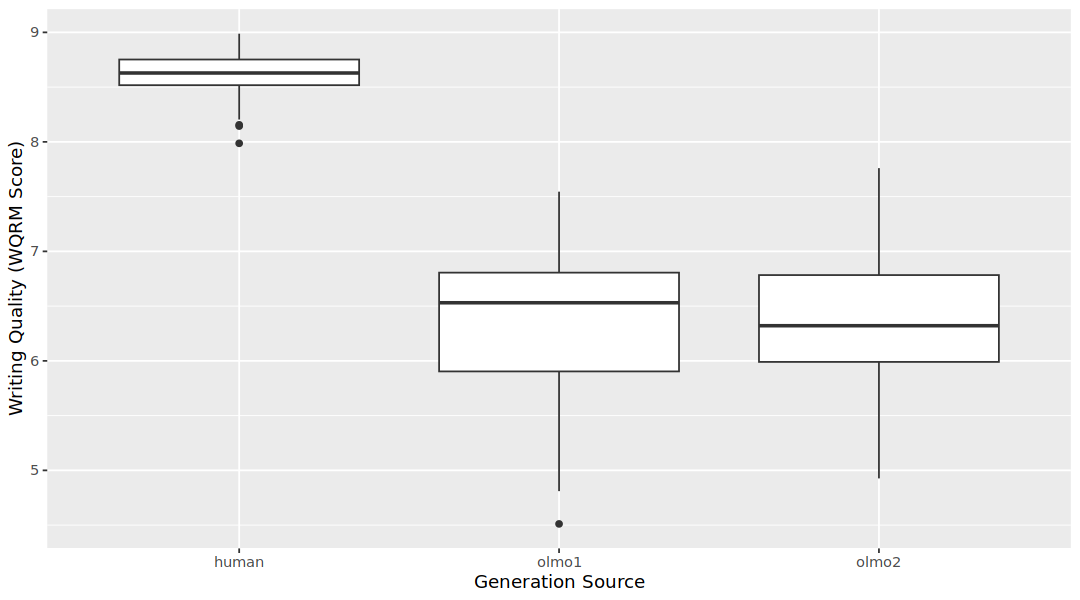

In [170]:
undup_nov_data <- nov_data[!duplicated(nov_data$gen_passage_id), ]
ggplot(undup_nov_data, aes(x = gen_source, y = WQRM_score)) + 
  geom_boxplot() +
  # x axis label: generation source
  labs(x = "Generation Source", y = "Writing Quality (WQRM Score)")
  
# save plot
ggsave("plots/writing_quality_by_gen_source.png", width = 6, height = 4, dpi = 300, bg = "white")

In [171]:
m_nov_wqrm = glmer(creative ~ WQRM_score 
                    + (1 | annotator)
                    + (1 | seed_passage_id),
               data = nov_data, family = binomial(link = "logit"))
summary(m_nov_wqrm)
print(r.squaredGLMM(m_nov_wqrm))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: creative ~ WQRM_score + (1 | annotator) + (1 | seed_passage_id)
   Data: nov_data

      AIC       BIC    logLik -2*log(L)  df.resid 
   5486.4    5517.1   -2739.2    5478.4     16027 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6378 -0.2266 -0.1688 -0.1276 12.2079 

Random effects:
 Groups          Name        Variance Std.Dev.
 seed_passage_id (Intercept) 0.3561   0.5968  
 annotator       (Intercept) 0.5070   0.7120  
Number of obs: 16031, groups:  seed_passage_id, 50; annotator, 26

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.26453    0.33024 -15.942  < 2e-16 ***
WQRM_score   0.25078    0.03639   6.892 5.49e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
WQRM_score -0.856

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                    R2m        R2c
theoretical 0.022052571 0.22530003
delta       0.004139062 0.04228672


In [172]:
formula_name <- "\\shortstack[l]{creative \\textasciitilde{} WQRM\\_score  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"

texreg(m_nov_wqrm,
       caption = "Mixed-effects logistic regression predicting creativity from passage-level WQRM scores",
       custom.model.names = formula_name,
       label = "tab:glmer_nov_src_front",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/nov_wqrm.tex")  # writes LaTeX table

The table was written to the file 'latex/nov_wqrm.tex'.




In [173]:
# get odds ratio
exp(fixef(m_nov_wqrm))

(Intercept)  WQRM_score 
0.005171817 1.285024668

In [174]:
# writing quality vs novelty
m_prag_wqrm = glmer(pragmatic ~ WQRM_score 
                    + (1 | annotator)
                    + (1 | seed_passage_id),
               data = prag_data, family = binomial(link = "logit"))
summary(m_prag_wqrm)
print(r.squaredGLMM(m_prag_wqrm))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pragmatic ~ WQRM_score + (1 | annotator) + (1 | seed_passage_id)
   Data: prag_data

      AIC       BIC    logLik -2*log(L)  df.resid 
   2825.6    2853.3   -1408.8    2817.6      7512 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.8673   0.0853   0.1647   0.2613   1.4226 

Random effects:
 Groups          Name        Variance Std.Dev.
 seed_passage_id (Intercept) 0.7526   0.8675  
 annotator       (Intercept) 1.8610   1.3642  
Number of obs: 7516, groups:  seed_passage_id, 50; annotator, 26

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.50651    0.47066   3.201  0.00137 ** 
WQRM_score   0.28099    0.04936   5.693 1.25e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
WQRM_score -0.750

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                    R2m       R2c
theoretical 0.019594323 0.4536425
delta       0.006535672 0.1513121


In [175]:
formula_name <- "\\shortstack[l]{pragmatic \\textasciitilde{} WQRM\\_score  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"

texreg(m_prag_wqrm,
       caption = "Mixed-effects logistic regression predicting pragmaticality from passage-level WQRM scores",
       custom.model.names = formula_name,
       label = "tab:glmer_nov_src_front",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/prag_wqrm.tex")  # writes LaTeX table

The table was written to the file 'latex/prag_wqrm.tex'.




In [176]:
exp(fixef(m_prag_wqrm))

(Intercept)  WQRM_score 
   4.510973    1.324438

# Frontier analysis

## load novelty data


    0     1 
17493   830 


    0     1 
17524   799 

[1] 18322    14

[1] 0


    0     1 
17493   829 


 human claude   gpt5  olmo1  olmo2 
  7657   1175   1116   4384   3990 

,batch,gen_passage_id,seed_passage_id,novel,meaningful,pragmatic,annotator_id,gen_source,ppl,WQRM_score,ai_likelihood,creative,annotator,ppl_log_std
,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>"
1,1,16897_human,16897,0,1,1,9,human,4529.581,8.509995,0.000136031,0,9,0.1540408
2,1,16897_human,16897,0,1,1,21,human,4529.581,8.509995,0.000136031,0,21,0.1540408
3,1,16897_human,16897,0,1,1,20,human,4529.581,8.509995,0.000136031,0,20,0.1540408


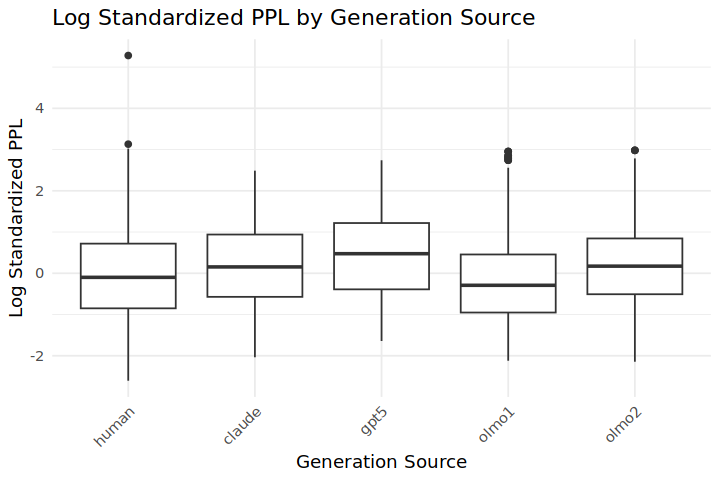

In [147]:
front_nov_data <- read.csv("../data/for_linear_models/prehlt_and_hlt.csv")

table(front_nov_data$novel)
# if pragmatic or meaningful is not na and is 0, set novel to 0 (ignore NA)
front_nov_data$creative <- ifelse((!is.na(front_nov_data$pragmatic) & front_nov_data$pragmatic == 0) | 
                             (!is.na(front_nov_data$meaningful) & front_nov_data$meaningful == 0), 0, front_nov_data$novel)
table(front_nov_data$creative)
    
front_nov_data$seed_passage_id <- as.factor(front_nov_data$seed_passage_id)
front_nov_data$annotator <- as.factor(front_nov_data$annotator_id)
front_nov_data$gen_source <- as.factor(front_nov_data$gen_source)
front_nov_data$gen_source <- relevel(front_nov_data$gen_source, ref = "human")
front_nov_data$ppl_log_std <- scale(log(front_nov_data$ppl))

options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(front_nov_data, aes(x=gen_source, y=ppl_log_std)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Log Standardized PPL by Generation Source",
       x="Generation Source",
       y="Log Standardized PPL") +
  theme(axis.text.x = element_text(angle=45, hjust=1))

# remove the outlier expression
front_nov_data <- front_nov_data[front_nov_data$ppl_log_std < 4, ]
dim(front_nov_data)
# number of unique annotators
length(unique(front_nov_data$expression))
table(front_nov_data$novel)
table(front_nov_data$gen_source)
# first few rows
head(front_nov_data, n=3)

## novelty analysis

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                    R2m        R2c
theoretical 0.022133291 0.22639870
delta       0.004157853 0.04253017
 gen_source   prob      SE  df asymp.LCL asymp.UCL
 human      0.0439 0.00735 Inf    0.0316    0.0608
 claude     0.0230 0.00651 Inf    0.0132    0.0399
 gpt5       0.0225 0.00649 Inf    0.0128    0.0394
 olmo1      0.0230 0.00447 Inf    0.0157    0.0336
 olmo2      0.0271 0.00521 Inf    0.0186    0.0394

Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 
 contrast       odds.ratio     SE  df null z.ratio p.value
 claude / human      0.513 0.1231 Inf    1  -2.781  0.0199
 gpt5 / human        0.501 0.1238 Inf    1  -2.797  0.0190
 olmo1 / human       0.512 0.0613 Inf    1  -5.590  <.0001
 olmo2 / human       0.606 0.0715 Inf    1  -4.244  0.0001

P value adjustment: dunnettx method for 4 tests 
Tests are performed on the log odds ratio scale 


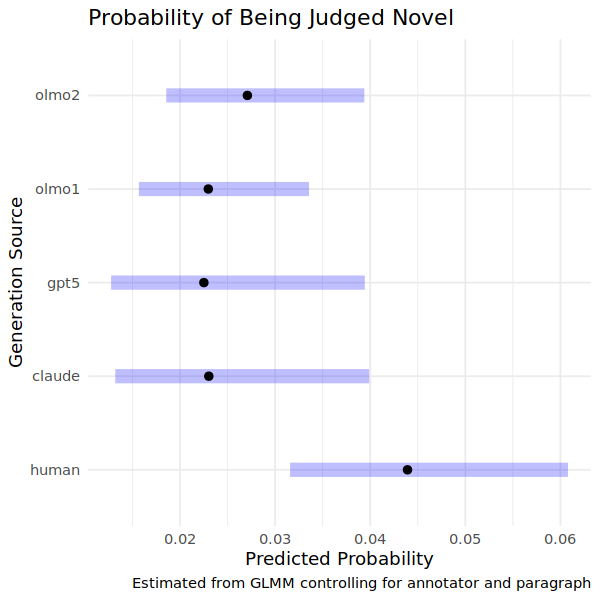

In [148]:
m_front_nov = glmer(creative ~  gen_source 
                    + (1 | annotator) 
                    + (1 | seed_passage_id), 
               data = front_nov_data, family = binomial(link = "logit"))
print(r.squaredGLMM(m_front_nov))
# summary(m_nov)
emm <- emmeans(m_front_nov, ~ gen_source, type = "response")

# View results
print(emm)

# Plot
options(repr.plot.width = 5, repr.plot.height = 5)
plot(emm) +
  labs(
    title = "Probability of Being Judged Novel",
    x = "Predicted Probability",
    y = "Generation Source",
    caption = "Estimated from GLMM controlling for annotator and paragraph"
  ) +
  theme_minimal()

contr = contrast(emm, "trt.vs.ctrl", ref = "human", type = "response")
# summary(contr)
print(summary(contr))
# confint_df = confint(contr)
# print(confint_df)

In [149]:

formula_name <- "\\shortstack[l]{creative \\textasciitilde{} gen\\_source  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"
# pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | seed_passage_id)
texreg(m_front_nov,
       caption = "Mixed-effects logistic regression predicting creativity from generation source (comparing humans and all models)",
       custom.model.names = formula_name,
       label = "tab:glmer_nov_src_front",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/nov_src.tex")  # writes LaTeX table

The table was written to the file 'latex/nov_src.tex'.




## load pragmatic data

In [177]:
front_prag_data <- read.csv("../data/for_linear_models/prehlt_and_hlt.csv")
# to reproduce exact paper results:
# front_prag_data <- read.csv("../data/for_linear_models/prehlt_only.csv")

table(front_prag_data$pragmatic, front_prag_data$gen_source)
# front_prag_data$pragmatic <- front_prag_data$pragmatic * front_prag_data$meaningful
# front_prag_data <- front_prag_data[front_prag_data$meaningful != 0, ]
table(front_prag_data$pragmatic, front_prag_data$gen_source)

# batch 11 seed_passage_id
batch_11_ids <- front_prag_data %>%
  filter(batch == 11) %>%
  pull(seed_passage_id) %>%
  unique()
# convert ids to "ID_human" format
human_batch11_ids <- paste0(sprintf("%02d", 
                      as.numeric(gsub("seed_passage_id_", "",
                       batch_11_ids))), "_human")
batch_11_gen_passage_ids <- front_prag_data %>%
  filter(batch == 11) %>%
  pull(gen_passage_id) %>%
  unique()

batch_11_annotators <- front_prag_data %>%
  filter(batch == 11) %>%
  pull(annotator_id) %>%
  unique()

# compare only gpt5, claude, and human
front_prag_data <- front_prag_data %>%
     filter( gen_passage_id %in% human_batch11_ids | gen_passage_id %in% batch_11_gen_passage_ids)

table(front_prag_data$gen_passage_id)
table(front_prag_data$meaningful, front_prag_data$pragmatic)
table(front_prag_data$gen_source, front_prag_data$pragmatic)
table(front_prag_data$gen_source, front_prag_data$meaningful)

# table(front_prag_data$gen_passage_id)
front_prag_data$seed_passage_id <- as.factor(front_prag_data$seed_passage_id)
front_prag_data$annotator <- as.factor(front_prag_data$annotator_id)
front_prag_data$gen_source <- as.factor(front_prag_data$gen_source)
front_prag_data$gen_source <- relevel(front_prag_data$gen_source, ref = "human")

front_prag_data$ppl_log_std <- scale(log(front_prag_data$ppl))
dim(front_prag_data)
head(front_prag_data)

   
    claude gpt5 human olmo1 olmo2
  0     12   43   204   303   160
  1    555  481  3400  1656  2045

   
    claude gpt5 human olmo1 olmo2
  0     12   43   204   303   160
  1    555  481  3400  1656  2045


11660_claude   11660_gpt5  11660_human 11680_claude   11680_gpt5  11680_human 
         240          225          141          168          208          140 
12838_claude   12838_gpt5  12838_human 14062_claude   14062_gpt5  14062_human 
         213          227          141          252          248          155 
  706_claude     706_gpt5    706_human 
         302          208          187 

   
       0    1
  0   31    0
  1   60 1390

        
           0   1
  claude  12 555
  gpt5    43 481
  human   36 354

        
           0   1
  claude   7 560
  gpt5    15 509
  human    9 381

[1] 3055   13

,batch,gen_passage_id,seed_passage_id,novel,meaningful,pragmatic,annotator_id,gen_source,ppl,WQRM_score,ai_likelihood,annotator,ppl_log_std
,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>"
1,5,12838_human,12838,0,1,1,1,human,568.12262,8.5971,3.708733e-06,1,-0.824248
2,5,12838_human,12838,0,1,1,4,human,568.12262,8.5971,3.708733e-06,4,-0.824248
3,5,12838_human,12838,0,1,1,17,human,568.12262,8.5971,3.708733e-06,17,-0.824248
4,5,12838_human,12838,0,NA,NA,17,human,33698.17427,8.5971,3.708733e-06,17,0.588854
5,5,12838_human,12838,0,NA,NA,1,human,33698.17427,8.5971,3.708733e-06,1,0.588854
6,5,12838_human,12838,0,NA,NA,17,human,49.44416,8.5971,3.708733e-06,17,-1.669263


In [178]:
# table(front_prag_data$annotator, front_prag_data$seed_passage_id )
table(front_prag_data$annotator, front_prag_data$batch )

    
       5   7  10  11
  1   47   0   0   0
  2    0 167   0   0
  3    0   0   0 571
  4   47   0   0   0
  8    0   0   0 574
  11   0   0  47   0
  12   0   0  47   0
  15   0   0   0 572
  17  47   0   0   0
  21   0   0  47 574
  22   0 158   0   0
  24   0 157   0   0

## prag vs ppl

In [179]:
m_front_prag_ppl = glmer(pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | seed_passage_id), 
               data = front_prag_data, family = binomial(link = "logit"),
               glmerControl(optimizer = "bobyqa"))

summary(m_front_prag_ppl)
print(r.squaredGLMM(m_front_prag_ppl))
print(linearHypothesis(m_front_prag_ppl, "ppl_log_std = 0"))
print(linearHypothesis(m_front_prag_ppl, c("ppl_log_std + ppl_log_std:gen_sourcegpt5 = 0")))
print(linearHypothesis(m_front_prag_ppl, c("ppl_log_std + ppl_log_std:gen_sourceclaude = 0")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 |  
    seed_passage_id)
   Data: front_prag_data
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
    614.0     656.4    -299.0     598.0      1473 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-16.3698   0.0926   0.1591   0.2840   0.6494 

Random effects:
 Groups          Name        Variance Std.Dev.
 annotator       (Intercept) 1.62240  1.2737  
 seed_passage_id (Intercept) 0.09223  0.3037  
Number of obs: 1481, groups:  annotator, 12; seed_passage_id, 5

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    2.6300     0.5249   5.010 5.44e-07 ***
ppl_log_std                    0.1593     0.2285   0.697   0.4857    
gen_sourceclaude               1.6601     0.8153   

Warning message:
“the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model.”


                   R2m       R2c
theoretical 0.10266907 0.4101107
delta       0.04134419 0.1651490
Linear hypothesis test

Hypothesis:
ppl_log_std = 0

Model 1: restricted model
Model 2: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | 
    seed_passage_id)

  Df  Chisq Pr(>Chisq)
1                     
2  1 0.4861     0.4857
Linear hypothesis test

Hypothesis:
ppl_log_std  + ppl_log_std:gen_sourcegpt5 = 0

Model 1: restricted model
Model 2: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | 
    seed_passage_id)

  Df  Chisq Pr(>Chisq)
1                     
2  1 0.9879     0.3203
Linear hypothesis test

Hypothesis:
ppl_log_std  + ppl_log_std:gen_sourceclaude = 0

Model 1: restricted model
Model 2: pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | 
    seed_passage_id)

  Df  Chisq Pr(>Chisq)
1                     
2  1 0.5855     0.4442


In [180]:
formula_name <- "\\shortstack[l]{pragmatic \\textasciitilde{} ppl\\_log\\_std * gen\\_source  \\\\ 
+ (1 \\textbar{} annotator) + \\\\ 
(1 \\textbar{} seed\\_passage\\_id)}"
# pragmatic ~ ppl_log_std * gen_source + (1 | annotator) + (1 | seed_passage_id)
texreg(m_front_prag_ppl,
       caption = "Mixed-effects logistic regression predicting creativity from standardized PPL (comparing humans and frontier models)",
       custom.model.names = formula_name,
       label = "tab:glmer_ppl_prag_src_front",
       float.pos = "htbp",
       booktabs = TRUE,
       single.row = TRUE,
       ci.force = TRUE,     # include confidence intervals
       ci.level = 0.95,
       file = "latex/prag_ppl_front.tex")  # writes LaTeX table

The table was written to the file 'latex/prag_ppl_front.tex'.


